In [1]:
import glob
import pandas as pd
import numpy as np
import sys
import operator
import numpy as np
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
import geopandas as gpd
from fiona.crs import from_epsg

%pylab inline
pd.options.display.max_columns = None

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# w r a n g l e + load
poi_pluto = gpd.GeoDataFrame(gpd.read_file("PLUTO/area_of_interest5.shp"))

files = glob.glob("data/*.xls")
dfs = [pd.read_excel(f, skiprows=4) for f in files]
for df in dfs:
    df.columns = ["_".join(x.strip().split(" ")) for x in df.columns]

manhattan_sales = pd.concat(dfs)
merged = manhattan_sales.merge(poi_pluto, left_on=["BLOCK", "LOT"], right_on=["Block", "Lot"])
merged["SALE_MONTH"] = merged["SALE_DATE"].apply(lambda x: str(x.year) + "-" + str(x.month))
l = list(merged.columns)
l.remove("geometry")
merged = merged.drop_duplicates(subset=l)
merged = merged[merged["SALE_PRICE"] > 1]
merged["APT"] = merged["ADDRESS"].str.split(",").apply(lambda x: x[1].strip() if len(x) > 1 else "")
def dude(x):
    return x["APARTMENT_NUMBER"].strip() if x["APARTMENT_NUMBER"].strip() else x["APT"]

merged["APARTMENT_NUMBER"] = merged["APARTMENT_NUMBER"].astype(str)
merged["APT_2"] = merged[["APT", "APARTMENT_NUMBER"]].apply(dude, axis=1)
merged["APT"] = merged["APT_2"]
merged = merged[merged["YearBuilt"] > 0].reset_index(drop=True)
df = merged

df["address_apt"] = df["Address"].apply(lambda x: x.strip() + " # ") + df["APT"]
# filter out things that arent apartments
df = df[df["APT"] != ''].reset_index(drop=True)
df["log_price"] = np.log(df["SALE_PRICE"])
df = df[df["log_price"] > 5].reset_index(drop=True) # 100k


### Regressions with basic variables

0.173818246509
0.286110646199
-0.00171153302708
-0.00537051132214


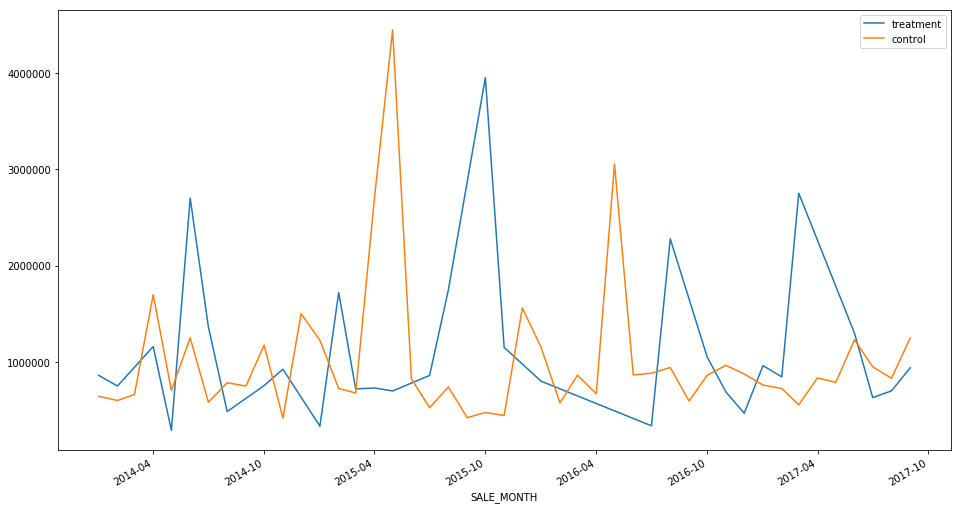

In [66]:
from datetime import datetime
cutoff = datetime(2017, 1, 1)

# make our features

# treatment and before / after
df["treatment"] = (df["distance"] < 200).astype(np.int)
df["after"] = (df["SALE_DATE"] >= cutoff).astype(np.int)
df["treatment_x_after"] = df["treatment"] * df["after"]


df["prewar"] = (df["YearBuilt"] < 1950).astype(np.int)
df["postwar"] = (df["YearBuilt"] >= 1950).astype(np.int)
df["new"] = (df["YearBuilt"] >= 2000).astype(np.int)
year_cols = "prewar + postwar + new"

two_or_more_sales = df.groupby(["Address", "APT"]).filter(lambda x: len(x) > 1)
only_before_after = two_or_more_sales.groupby(["ADDRESS", "APT"]).filter(lambda x: x.SALE_DATE.min() < cutoff\
                                                               and x.SALE_DATE.max() >= cutoff)

import bedrooms as br
reload(br)
with_br = only_before_after.merge(br.br, left_on="address_apt", right_on='addy')

import statsmodels.formula.api as smf


basic_formula = "log_price ~ treatment + after + treatment_x_after"
reg_all = smf.ols(basic_formula, data=df).fit()
reg_two = smf.ols(basic_formula, data=two_or_more_sales).fit()
reg_only = smf.ols(basic_formula, data=only_before_after).fit()
reg_br = smf.ols(basic_formula + " + bedrooms", data=with_br).fit()

print reg_all.params['treatment_x_after']
print reg_two.params['treatment_x_after']
print reg_only.params['treatment_x_after']
print reg_br.params['treatment_x_after']

fig = plt.figure(figsize=(16, 9))

median_treatment = two_or_more_sales[two_or_more_sales["treatment"] == 1].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_control = two_or_more_sales[two_or_more_sales["treatment"] == 0].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_treatment.index = median_treatment.index.map(lambda x: pd.to_datetime(x))
median_control.index = median_control.index.map(lambda x: pd.to_datetime(x))

ax = median_treatment.plot(figsize=(16, 9), label="treatment")
median_control.plot(ax=ax, label="control")
ax.legend()

### Regressions with east of second avenue

0.100203234312
0.298240755224
0.149469206908
0.145568546267


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     62.63
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           2.48e-30
Time:                        08:22:13   Log-Likelihood:                -108.17
No. Observations:                 146   AIC:                             226.3
Df Residuals:                     141   BIC:                             241.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.8767      0.104    123.631      0.000      12.671      13.083
treatment            -0.3148      0.127     -2.484      0.014      -0.565      -0.064
after                 0.1062      0.108      0.986      0.326      -0.107       0.319
treatment_x_after     0.1456      0.177      0.822      0.412      -0.205       0.496
bedrooms              0.6501      0.045     14.522      0.000       0.562       0.739
==============================================================================
Omnibus:                       34.172   Durbin-Watson:                   0.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.716
Skew:                           0.948   Prob(JB):                     1.09e-18
Kurtosis:                       6.163   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

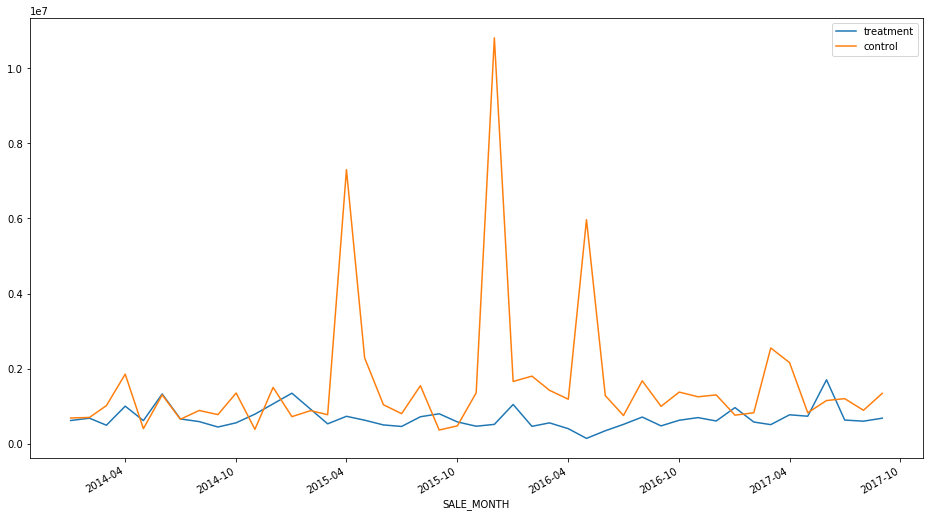

In [67]:
from datetime import datetime
cutoff = datetime(2017, 1, 1)

# make our features

# treatment and before / after
df["treatment"] = df["east_or__1"]
df["after"] = (df["SALE_DATE"] >= cutoff).astype(np.int)
df["treatment_x_after"] = df["treatment"] * df["after"]


df["prewar"] = (df["YearBuilt"] < 1950).astype(np.int)
df["postwar"] = (df["YearBuilt"] >= 1950).astype(np.int)
df["new"] = (df["YearBuilt"] >= 2000).astype(np.int)
year_cols = "prewar + postwar + new"

two_or_more_sales = df.groupby(["Address", "APT"]).filter(lambda x: len(x) > 1)
only_before_after = two_or_more_sales.groupby(["ADDRESS", "APT"]).filter(lambda x: x.SALE_DATE.min() < cutoff\
                                                               and x.SALE_DATE.max() >= cutoff)

import bedrooms as br
reload(br)
with_br = only_before_after.merge(br.br, left_on="address_apt", right_on='addy')

import statsmodels.formula.api as smf


basic_formula = "log_price ~ treatment + after + treatment_x_after"
reg_all = smf.ols(basic_formula, data=df).fit()
reg_two = smf.ols(basic_formula, data=two_or_more_sales).fit()
reg_only = smf.ols(basic_formula, data=only_before_after).fit()
reg_br = smf.ols(basic_formula + " + bedrooms", data=with_br).fit()

print reg_all.params['treatment_x_after']
print reg_two.params['treatment_x_after']
print reg_only.params['treatment_x_after']
print reg_br.params['treatment_x_after']

fig = plt.figure(figsize=(16, 9))

median_treatment = two_or_more_sales[two_or_more_sales["treatment"] == 1].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_control = two_or_more_sales[two_or_more_sales["treatment"] == 0].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_treatment.index = median_treatment.index.map(lambda x: pd.to_datetime(x))
median_control.index = median_control.index.map(lambda x: pd.to_datetime(x))

ax = median_treatment.plot(figsize=(16, 9), label="treatment")
median_control.plot(ax=ax, label="control")
ax.legend()
reg_br.summary()

## Use Log Price

It is more normal by tests.

In [ ]:
df["log_price"].hist()

### LaTeX Formatting

In [44]:
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,FID_1,distance,east_or__1,FID_12,distance_1,geometry,SALE_MONTH,APT,APT_2,address_apt,log_price,treatment,after,treatment_x_after,prewar,postwar,new
0,1,HARLEM-EAST,09 COOPS - WALKUP APARTMENTS,2,1624,43,,C6,"156 EAST 97TH STREET, 1",,10029,.,.,.,.,.,1930,2,C6,200000,2017-02-06,MN,1624,43,111,158.02,1000,02,5,10029,E053,23,2820,1,11,1A,156 EAST 97 STREET,R7-2,,,,,,,,,,N,C6,02,0,P,156 EAST 97TH STREET,2725,8635,0,8635,0,0,0,0,0,0,2,1,5.0,18,18,27.0,100.92,27.0,66.0,,2,N,5,2,57600.0,483300.0,57600.0,307134.0,1930,1939,2006,,,3.17,3.44,0.0,6.5,1,1.016240e+09,0,015802,998184,225631,6b,,108S045,10603,,0.0,,1,16V2,0,263.791787,2784.667103,5922,292.976495,0,5922,121.870696,"POLYGON ((998221.8100000024 225671.1615999937,...",2017-2,1,1,156 EAST 97 STREET # 1,12.206073,0,1,0,1,0,0
